In [18]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


### Evaluación de consultas generales

In [19]:

csv_filename = f"data/evaluation_results_20250912_190122.csv"
evaluation_results = pd.read_csv(csv_filename)
evaluation_results.to_csv(csv_filename, index=False)
SAMPLE_SIZE = 20

evaluation_results.head()

,question_id,original_index,query,expected_law_id,expected_law_item_id,found_law_ids,found_law_item_ids,law_correct,law_item_correct,both_correct,num_citations,response_length,reasoning_length
0,0,0,Según el Artículo 17 de la Ley de Enjuiciamien...,30,6545,[30],[6545],True,True,True,1,1547,425
1,1,1,¿Puede el deudor optar por una prestación ilíc...,2,1323,[2],[1323],True,True,True,1,559,311
2,2,2,¿El juez debe registrar en el sumario todas la...,25,4150,[25],[4150],True,True,True,1,627,293
3,3,3,"¿Según el Artículo 43 de la Ley, un policía qu...",10,2809,[10],[2809],True,True,True,1,1033,323
4,4,4,"Según el Artículo 24 de la ley, ¿cómo deben es...",47,7860,[],[],False,False,False,0,821,258


In [20]:

# Calcular métricas finales
total_evaluated = len(evaluation_results)
law_success = evaluation_results['law_correct'].sum()
law_item_success = evaluation_results['law_item_correct'].sum()
both_success = evaluation_results['both_correct'].sum()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
law_accuracy = (law_success / total_evaluated) * 100 if total_evaluated > 0 else 0
item_accuracy = (law_item_success / total_evaluated) * 100 if total_evaluated > 0 else 0
both_accuracy = (both_success / total_evaluated) * 100 if total_evaluated > 0 else 0
evaluation_errors = evaluation_results[evaluation_results['both_correct'] == 0]

print(f"\n📊 MÉTRICAS FINALES:")
print(f"   • Total evaluado: {total_evaluated} preguntas")
print(f"   • Precisión Ley: {law_success}/{total_evaluated} ({law_accuracy:.1f}%)")
print(f"   • Precisión Artículo: {law_item_success}/{total_evaluated} ({item_accuracy:.1f}%)")
print(f"   • Precisión Ambos: {both_success}/{total_evaluated} ({both_accuracy:.1f}%)")
print(f"   • Tasa de error: {len(evaluation_errors) / SAMPLE_SIZE * 100:.1f}%")


📊 MÉTRICAS FINALES:
   • Total evaluado: 20 preguntas
   • Precisión Ley: 17/20 (85.0%)
   • Precisión Artículo: 14/20 (70.0%)
   • Precisión Ambos: 14/20 (70.0%)
   • Tasa de error: 30.0%


🎨 Generando análisis visual de resultados...


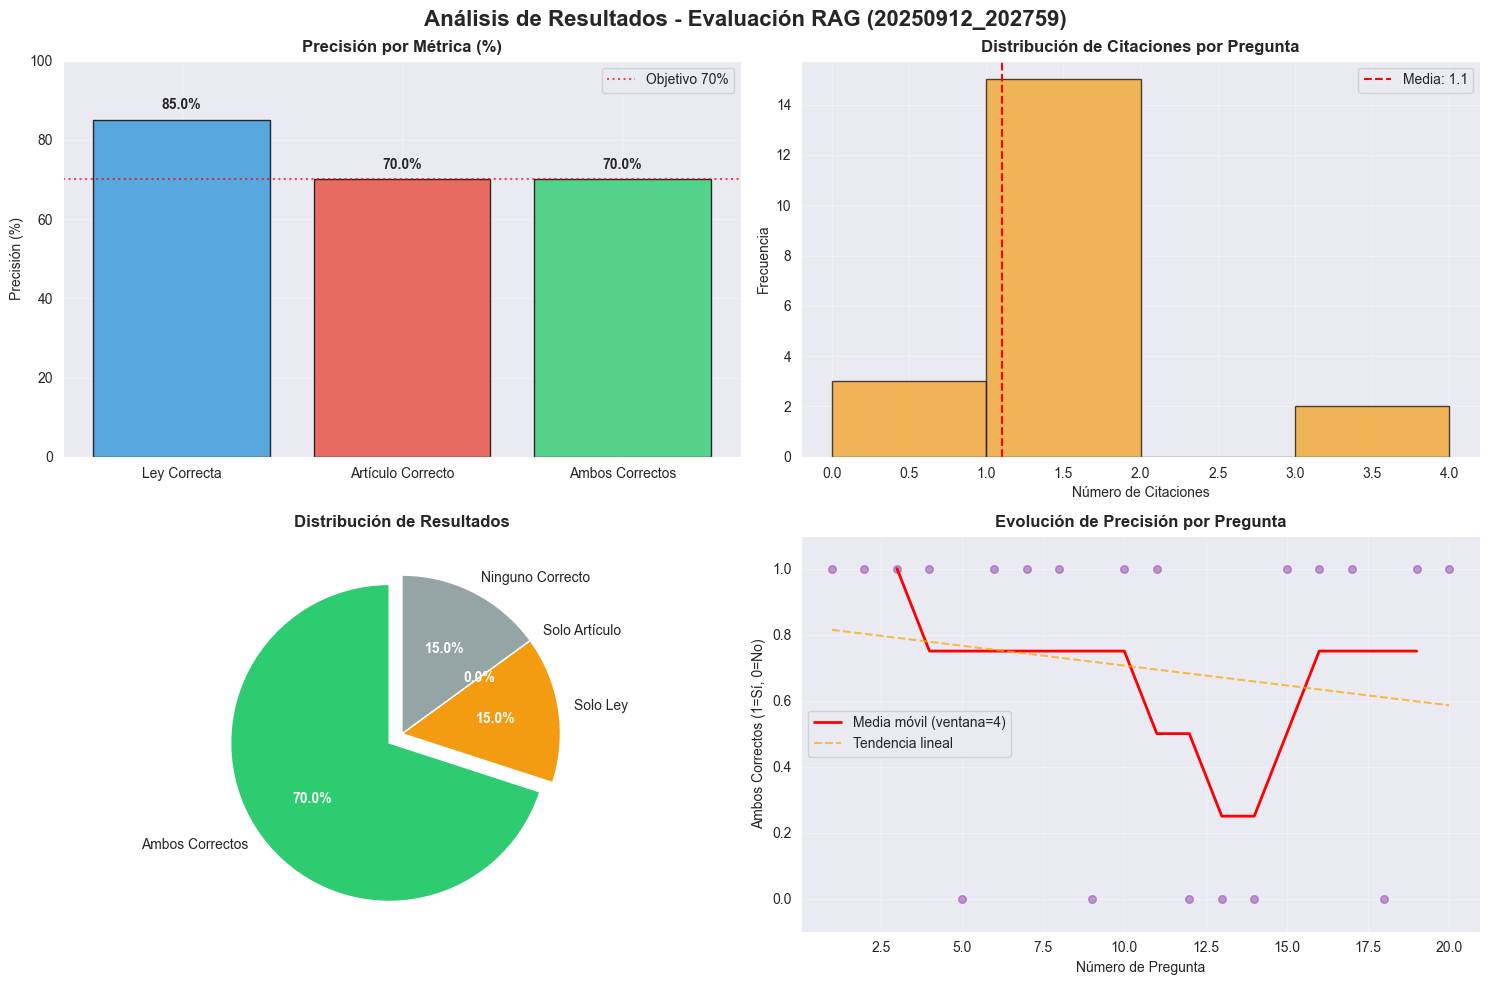

✅ Gráficos guardados en: data/evaluation_results_20250912_202759.png


In [21]:
# === ANÁLISIS VISUAL DE RESULTADOS ===
print("🎨 Generando análisis visual de resultados...")

# DataFrame -> lista de diccionarios
evaluation_results = evaluation_results.to_dict(orient="records")

# Crear figura para análisis de resultados
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Análisis de Resultados - Evaluación RAG ({timestamp})', fontsize=16, fontweight='bold')

# 1. Gráfico de barras con precisión por métrica
metrics = ['Ley Correcta', 'Artículo Correcto', 'Ambos Correctos']
accuracies = [law_accuracy, item_accuracy, both_accuracy]
colors = ['#3498DB', '#E74C3C', '#2ECC71']

bars = ax1.bar(metrics, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Precisión por Métrica (%)', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.set_ylabel('Precisión (%)')
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 2,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Añadir línea de objetivo (por ejemplo, 70%)
ax1.axhline(y=70, color='red', linestyle=':', alpha=0.7, label='Objetivo 70%')
ax1.legend()

# 2. Distribución de número de citaciones
if evaluation_results:
    citations_counts = [r['num_citations'] for r in evaluation_results]
    ax2.hist(citations_counts, bins=max(1, len(set(citations_counts))),
             alpha=0.7, color='#F39C12', edgecolor='black')
    ax2.set_title('Distribución de Citaciones por Pregunta', fontweight='bold')
    ax2.set_xlabel('Número de Citaciones')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(np.mean(citations_counts), color='red', linestyle='--',
                label=f'Media: {np.mean(citations_counts):.1f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Gráfico de pizza con distribución de resultados
only_law = law_success - both_success
only_item = law_item_success - both_success
neither = total_evaluated - law_success - law_item_success + both_success

sizes = [both_success, only_law, only_item, neither]
labels = ['Ambos Correctos', 'Solo Ley', 'Solo Artículo', 'Ninguno Correcto']
colors_pie = ['#2ECC71', '#F39C12', '#E74C3C', '#95A5A6']
explode = (0.1, 0, 0, 0)  # Destacar "Ambos Correctos"

wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie,
                                   autopct='%1.1f%%', startangle=90, explode=explode)
ax3.set_title('Distribución de Resultados', fontweight='bold')

# Mejorar el formato de los porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Tendencia de precisión a lo largo de las preguntas
if evaluation_results:
    correct_trend = [r['both_correct'] for r in evaluation_results]
    question_numbers = range(1, len(correct_trend) + 1)

    # Calcular media móvil para suavizar la tendencia
    window_size = min(10, len(correct_trend) // 5)
    if window_size > 1:
        moving_avg = pd.Series(correct_trend).rolling(window=window_size, center=True).mean()
        ax4.plot(question_numbers, moving_avg, color='red', linewidth=2,
                 label=f'Media móvil (ventana={window_size})')

    ax4.scatter(question_numbers, correct_trend, alpha=0.6, color='#9B59B6', s=30)
    ax4.set_title('Evolución de Precisión por Pregunta', fontweight='bold')
    ax4.set_xlabel('Número de Pregunta')
    ax4.set_ylabel('Ambos Correctos (1=Sí, 0=No)')
    ax4.set_ylim(-0.1, 1.1)
    ax4.grid(True, alpha=0.3)

    if window_size > 1:
        ax4.legend()

    # Añadir línea de tendencia general
    from numpy.polynomial.polynomial import Polynomial

    if len(question_numbers) > 5:
        p = Polynomial.fit(question_numbers, correct_trend, 1)
        trend_line = p(question_numbers)
        ax4.plot(question_numbers, trend_line, '--', color='orange', alpha=0.7,
                 label='Tendencia lineal')
        ax4.legend()

plt.tight_layout()
plt.savefig(f'data/evaluation_results_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráficos guardados en: data/evaluation_results_{timestamp}.png")


### Análisis de consultas ambiguas

In [22]:

csv_filename = f"data/rag_validation_20250911_105020.csv"
evaluation_results = pd.read_csv(csv_filename)
evaluation_results.to_csv(csv_filename, index=False)
SAMPLE_SIZE = 20

evaluation_results.head()

,question_id,query,expected_law_id,expected_law_item_id,found_law_ids,found_law_item_ids,law_correct,law_item_correct,both_correct,num_citations
0,0,¿Qué requisito debe cumplir el interesado para...,8,2718,[],[],False,False,False,0
1,1,En un caso donde un hijo natural ha sido recon...,2,8993,"[2, 2, 2, 2]","[8993, 10580, 1136, 1137]",True,True,True,4
2,2,"Si una persona fallece y deja bienes, ¿en qué ...",2,848,"[1, 1]","[657, 659]",False,False,False,2
3,3,¿Qué requisitos debe cumplir un candidato para...,32,6725,"[10, 10, 10]","[9989, 583, 2799]",False,False,False,3
4,4,¿En qué circunstancias el juez puede autorizar...,2,8976,[1],[52],False,False,False,1


In [23]:

# Calcular métricas finales
total_evaluated = len(evaluation_results)
law_success = evaluation_results['law_correct'].sum()
law_item_success = evaluation_results['law_item_correct'].sum()
both_success = evaluation_results['both_correct'].sum()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
law_accuracy = (law_success / total_evaluated) * 100 if total_evaluated > 0 else 0
item_accuracy = (law_item_success / total_evaluated) * 100 if total_evaluated > 0 else 0
both_accuracy = (both_success / total_evaluated) * 100 if total_evaluated > 0 else 0
evaluation_errors = evaluation_results[evaluation_results['both_correct'] == 0]

print(f"\n📊 MÉTRICAS FINALES:")
print(f"   • Total evaluado: {total_evaluated} preguntas")
print(f"   • Precisión Ley: {law_success}/{total_evaluated} ({law_accuracy:.1f}%)")
print(f"   • Precisión Artículo: {law_item_success}/{total_evaluated} ({item_accuracy:.1f}%)")
print(f"   • Precisión Ambos: {both_success}/{total_evaluated} ({both_accuracy:.1f}%)")
print(f"   • Tasa de error: {len(evaluation_errors) / SAMPLE_SIZE * 100:.1f}%")


📊 MÉTRICAS FINALES:
   • Total evaluado: 100 preguntas
   • Precisión Ley: 16/100 (16.0%)
   • Precisión Artículo: 10/100 (10.0%)
   • Precisión Ambos: 10/100 (10.0%)
   • Tasa de error: 450.0%


🎨 Generando análisis visual de resultados...


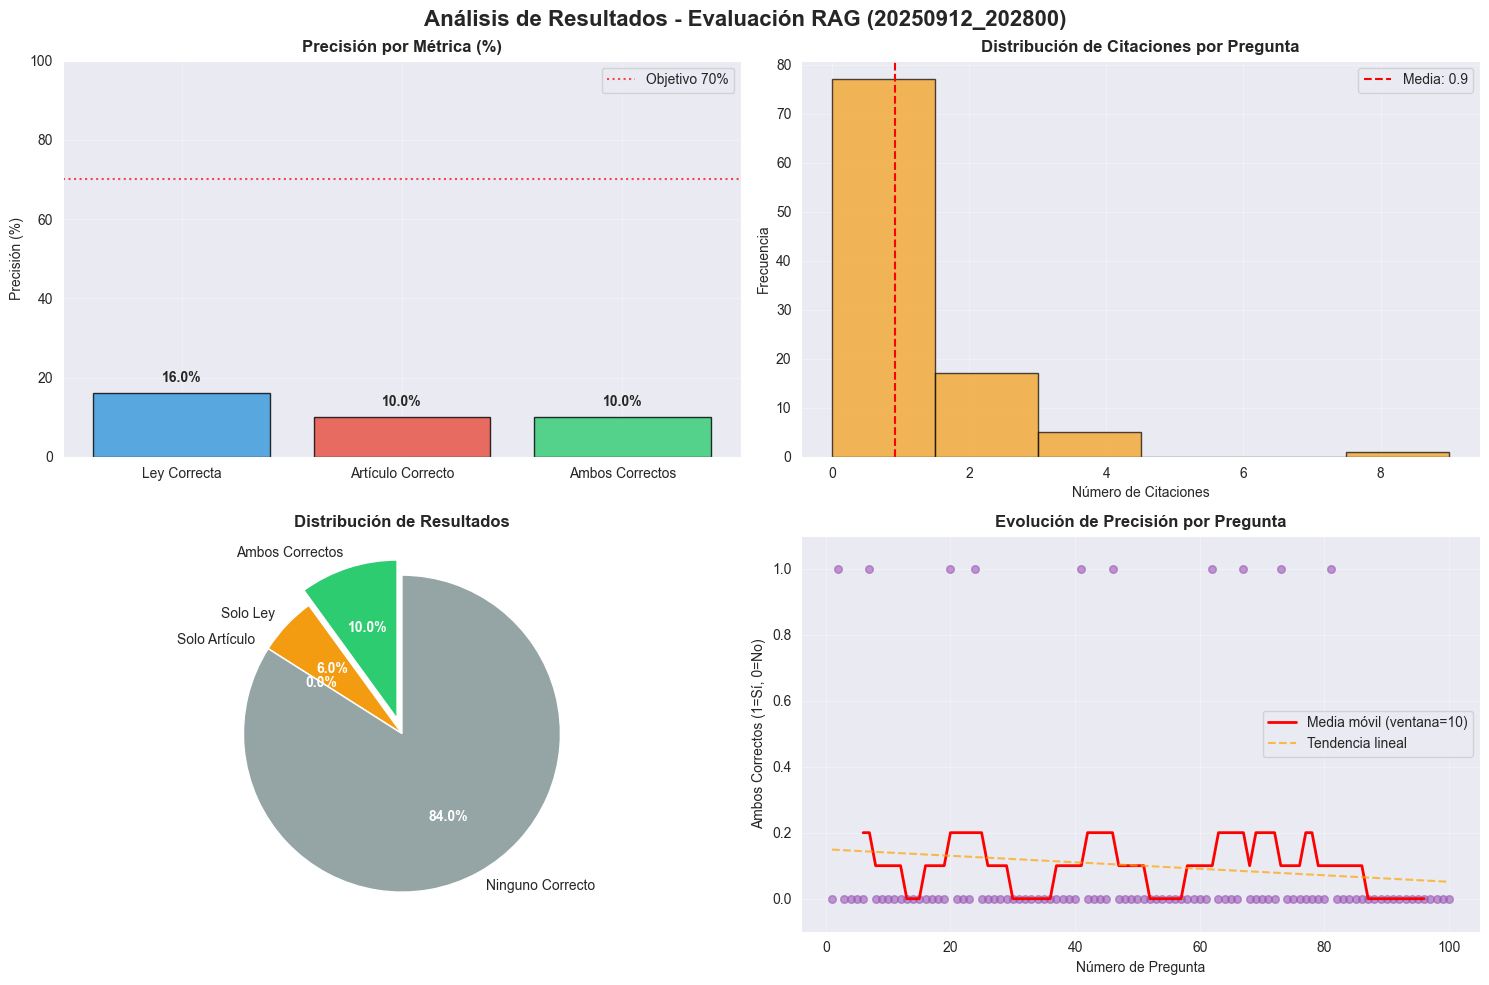

✅ Gráficos guardados en: data/evaluation_results_20250912_202800.png


In [24]:
# === ANÁLISIS VISUAL DE RESULTADOS ===
print("🎨 Generando análisis visual de resultados...")

# DataFrame -> lista de diccionarios
evaluation_results = evaluation_results.to_dict(orient="records")

# Crear figura para análisis de resultados
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Análisis de Resultados - Evaluación RAG ({timestamp})', fontsize=16, fontweight='bold')

# 1. Gráfico de barras con precisión por métrica
metrics = ['Ley Correcta', 'Artículo Correcto', 'Ambos Correctos']
accuracies = [law_accuracy, item_accuracy, both_accuracy]
colors = ['#3498DB', '#E74C3C', '#2ECC71']

bars = ax1.bar(metrics, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Precisión por Métrica (%)', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.set_ylabel('Precisión (%)')
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 2,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Añadir línea de objetivo (por ejemplo, 70%)
ax1.axhline(y=70, color='red', linestyle=':', alpha=0.7, label='Objetivo 70%')
ax1.legend()

# 2. Distribución de número de citaciones
if evaluation_results:
    citations_counts = [r['num_citations'] for r in evaluation_results]
    ax2.hist(citations_counts, bins=max(1, len(set(citations_counts))),
             alpha=0.7, color='#F39C12', edgecolor='black')
    ax2.set_title('Distribución de Citaciones por Pregunta', fontweight='bold')
    ax2.set_xlabel('Número de Citaciones')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(np.mean(citations_counts), color='red', linestyle='--',
                label=f'Media: {np.mean(citations_counts):.1f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Gráfico de pizza con distribución de resultados
only_law = law_success - both_success
only_item = law_item_success - both_success
neither = total_evaluated - law_success - law_item_success + both_success

sizes = [both_success, only_law, only_item, neither]
labels = ['Ambos Correctos', 'Solo Ley', 'Solo Artículo', 'Ninguno Correcto']
colors_pie = ['#2ECC71', '#F39C12', '#E74C3C', '#95A5A6']
explode = (0.1, 0, 0, 0)  # Destacar "Ambos Correctos"

wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie,
                                   autopct='%1.1f%%', startangle=90, explode=explode)
ax3.set_title('Distribución de Resultados', fontweight='bold')

# Mejorar el formato de los porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Tendencia de precisión a lo largo de las preguntas
if evaluation_results:
    correct_trend = [r['both_correct'] for r in evaluation_results]
    question_numbers = range(1, len(correct_trend) + 1)

    # Calcular media móvil para suavizar la tendencia
    window_size = min(10, len(correct_trend) // 5)
    if window_size > 1:
        moving_avg = pd.Series(correct_trend).rolling(window=window_size, center=True).mean()
        ax4.plot(question_numbers, moving_avg, color='red', linewidth=2,
                 label=f'Media móvil (ventana={window_size})')

    ax4.scatter(question_numbers, correct_trend, alpha=0.6, color='#9B59B6', s=30)
    ax4.set_title('Evolución de Precisión por Pregunta', fontweight='bold')
    ax4.set_xlabel('Número de Pregunta')
    ax4.set_ylabel('Ambos Correctos (1=Sí, 0=No)')
    ax4.set_ylim(-0.1, 1.1)
    ax4.grid(True, alpha=0.3)

    if window_size > 1:
        ax4.legend()

    # Añadir línea de tendencia general
    from numpy.polynomial.polynomial import Polynomial

    if len(question_numbers) > 5:
        p = Polynomial.fit(question_numbers, correct_trend, 1)
        trend_line = p(question_numbers)
        ax4.plot(question_numbers, trend_line, '--', color='orange', alpha=0.7,
                 label='Tendencia lineal')
        ax4.legend()

plt.tight_layout()
plt.savefig(f'data/evaluation_results_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráficos guardados en: data/evaluation_results_{timestamp}.png")
